# Book Recommendation Engine using KNN
We will create a book recommendation algorithm using K-Nearest Neighbors. Our goal is to obtain 5 recommended books based on the book consulted (input)

We use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users.

#  Import Statements


In [1]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import time
import gc
import argparse
# utils import
from fuzzywuzzy import fuzz
# data science imports
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Load the Data

In [3]:
#get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2022-10-26 03:40:14--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  19.0MB/s    in 1.3s    

2022-10-26 03:40:16 (19.0 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [4]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

# Preliminary Data Exploration 🔎
We'll first run a quick statistical analysis of the data. We will check for null values, get the general sense of the data and the types, to see if they reflect what's shown in the table above.

### Books Dataframe

In [5]:
df_books.shape

(271379, 3)

In [6]:
print(f"Dataframe Yearly has {df_books.shape[0]} rows and {df_books.shape[1]} columns")

Dataframe Yearly has 271379 rows and 3 columns


In [7]:
# examine the data types
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    271379 non-null  object
 1   title   271379 non-null  object
 2   author  271378 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB


In [8]:
df_books.describe(include='object').T

,count,unique,top,freq
isbn,271379,271379,0195153448,1
title,271379,242154,Selected Poems,27
author,271378,102042,Agatha Christie,632


In [9]:
df_books.sample(5)

,isbn,title,author
22709,0843108118,Mr. Silly (Mr. Men Books),Hargreaves
42916,1588276880,Awakening &amp; to Let,John Galsworthy
94569,0786002433,Echoes of the Heart,Michele Yount Thomas
244604,1557736170,"Stalker (Psi Man, No 5)",David Peters
262960,0786710977,Keeping Faith: A Father-Son Story About Love a...,John Schaeffer


### Ratings Dataframe

In [10]:
df_ratings.shape

(1149780, 3)

In [11]:
print(f"Dataframe ratings has {df_ratings.shape[0]} rows and {df_ratings.shape[1]} columns")

Dataframe ratings has 1149780 rows and 3 columns


In [12]:
# examine the data types
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


In [13]:
df_ratings.rating.describe()

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [14]:
df_ratings.sample(5)

,user,isbn,rating
757483,183138,0140268448,0.0
457761,110029,0330250817,0.0
571042,137211,0060907835,0.0
300237,71470,1881052443,0.0
942674,228571,0451180313,7.0


# Data Cleaning - Check for Missing Values and Duplicates

In [15]:
print(f'Missing values in books data?: {df_books.isna().values.any()}')
print(f'Duplicated values in books data?: {df_books.duplicated().values.any()}')

Missing values in books data?: True
Duplicated values in books data?: False


In [16]:
print(f'Missing values in rating data?: {df_ratings.isna().values.any()}')
print(f'Duplicated values in rating data?: {df_ratings.duplicated().values.any()}')

Missing values in rating data?: False
Duplicated values in rating data?: False


In [17]:
# Get all rows with NaN values.
df_books[df_books.isna().any(axis=1)]

,isbn,title,author
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN


In [18]:
# Now we need to get all affected reviews.
book_code = df_books[df_books.isna().any(axis=1)].isbn
df_ratings[df_ratings.isbn == book_code.iloc[0]].user.count()

1

In [19]:
df_books = df_books.dropna()
print(f'Missing values in books data?: {df_books.isna().values.any()}')

Missing values in books data?: False


In [20]:
# Lets drop the review from dropped book.
indexBook = df_ratings[df_ratings.isbn == book_code.iloc[0]].index
df_ratings.drop(indexBook , inplace=True)
df_ratings[df_ratings.isbn == book_code.iloc[0]].user.count()

0

# EDA

Inspecting the distributions

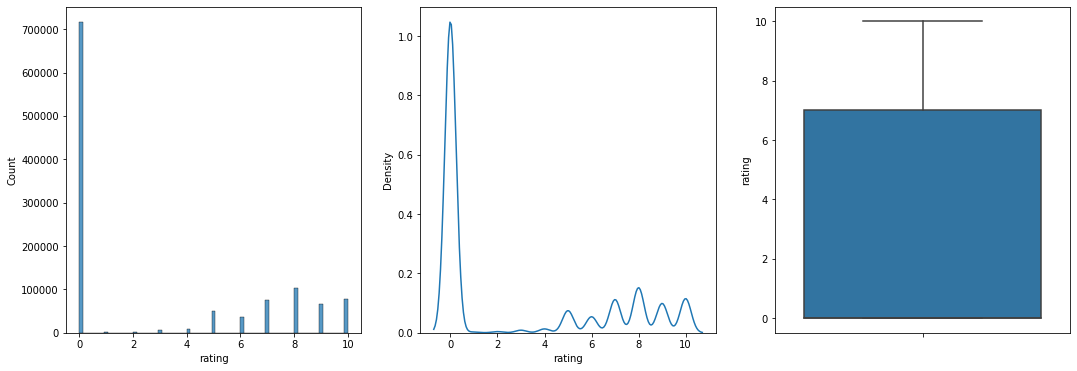

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
sns.histplot(data=df_ratings, x='rating', ax=ax[0])
sns.kdeplot(data=df_ratings, x='rating', ax=ax[1])
sns.boxplot(y ='rating', data=df_ratings, ax=ax[2])
plt.show()

# Content Based Recommendation System
The recommendation system works on the principle of similar content. If a user reads a book, the system will search for other books with similar content or in the same genre as the movie the user is reading. There are several fundamental attributes that are used to calculate similarity when searching for similar content.

# Remove otuliers

To ensure statistical significance, we will remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

In [22]:
# filter data
book_rating_thres = 100
user_rating_thres = 200
#Filter books
df_books_cnt = pd.DataFrame(df_ratings.groupby('isbn').size(), columns=['count'])
pop_books = list(set(df_books_cnt.query('count >= @book_rating_thres').index))  # noqa

popular_books_filter = df_books.isbn.isin(pop_books).values
# Get the books with more than 100 ratings.
df_rated_books = df_books[popular_books_filter]

#Filter users
df_users_cnt = pd.DataFrame(df_ratings.groupby('user').size(), columns=['count'])
active_users = list(set(df_users_cnt.query('count >= @user_rating_thres').index))  # noqa

users_filter = df_ratings.user.isin(active_users).values

# Filtering ratings by users with less than 200 ratings and books with less than 100 ratings.
df_ratings_f = df_ratings[users_filter]
df_ratings_f = df_ratings_f[df_ratings_f['isbn'].isin(df_rated_books.isbn)]

df_ratings_f.shape

(49517, 3)

In [23]:
book_popularity_thres = 50
#Filter rating. We need to find out which books are popular and filter out lesser-known books.
df_ratings_cnt = pd.DataFrame(df_ratings_f.groupby('isbn').agg({'rating': pd.Series.count}))
df_ratings_cnt.sort_values('rating', ascending=False, inplace=True)
popular_books = df_ratings_cnt.query('rating >= @book_popularity_thres')  # noqa

books_over_thres = list(set(popular_books.index)) 

books_filter_thres = df_rated_books.isbn.isin(books_over_thres).values

# Get the books with more than 50 points of rating.
df_popular_books = df_rated_books[books_filter_thres]

rated_books_filter_thres = df_ratings_f.isbn.isin(books_over_thres).values

# Get the books with more than 50 points of rating.
df_ratings_filtered = df_ratings_f[rated_books_filter_thres]

#Final Book df.
df_popular_books.shape

(491, 3)

In [24]:
# Combine the rating data with the total rating count data.
popular_books.reset_index(inplace=True)
popular_books.rename(columns = {'rating': 'rating_count'}, inplace=True)

df_ratings_filtered_final = df_ratings_filtered.merge(popular_books, left_on = 'isbn', right_on = 'isbn', how = 'left')

#Final rating df.
df_ratings_filtered_final.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,user,isbn,rating,rating_count
0,277427,002542730X,10.0,80
1,277427,0060930535,0.0,133
2,277427,0060934417,0.0,108
3,277427,0061009059,9.0,108
4,277427,0140067477,0.0,68


In [25]:
# pivot and create book-user matrix
book_user_mat = df_ratings_filtered_final.pivot(index='isbn', columns='user', values='rating').fillna(0)
# create mapper from book title to index
book_to_idx = {
    book: i for i, book in 
    enumerate(list(df_popular_books.set_index('isbn').loc[book_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
book_user_mat_sparse = csr_matrix(book_user_mat.values)

In [39]:
def fuzzy_matching(mapper, fav_book, verbose=True):
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_book.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('No matches found')
        return
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_book, n_recommendations):
    # fit
    model_knn.fit(data)
    # get input book index
    print('You have input book:', fav_book)
    print('......\n\n')
    idx = fuzzy_matching(mapper, fav_book, verbose=True)
    # inference
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_book))

    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [33]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
# fit
model_knn.fit(book_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [42]:
# Input book.
my_favorite = "Where the Heart Is (Oprah's Book Club (Paperback))"

make_recommendation(
    model_knn=model_knn,
    data=book_user_mat_sparse,
    fav_book=my_favorite,
    mapper=book_to_idx,
    n_recommendations=5)

You have input book: Where the Heart Is (Oprah's Book Club (Paperback))
......


Recommendations for Where the Heart Is (Oprah's Book Club (Paperback)):
1: Icy Sparks, with distance of 0.8064315915107727
2: I'll Be Seeing You, with distance of 0.8016210794448853
3: The Surgeon, with distance of 0.7699410915374756
4: I Know This Much Is True, with distance of 0.7677075266838074
5: The Lovely Bones: A Novel, with distance of 0.7234864234924316
